# Import and misc

In [1]:
# Instal latest torch and torchaudio
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.8 MB/s 
     |████████████████████████████████| 182 kB 15.4 MB/s 
     |████████████████████████████████| 166 kB 48.1 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 166 kB 48.2 MB/s 
     |████████████████████████████████| 162 kB 40.3 MB/s 
     |████████████████████████████████| 162 kB 71.1 MB/s 
     |████████████████████████████████| 158 kB 56.9 MB/s 
     |████████████████████████████████| 157 kB 56.2 MB/s 
     |████████████████████████████████| 157 kB 71.7 MB/s 
     |████████████████████████████████| 157 kB 54.7 MB/s 
     |████████████████████████████████| 157 kB 42.9 MB/s 
     |████████████████████████████████| 157 kB 50.6 MB/s 
     |████████████████████████████████| 157 kB 52.1 MB/s 
     |████████████████████████████████| 157 kB 50.4 MB/s 
     |████████████████████████████

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
import wandb

In [3]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 20 #change

# Data

In [5]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 19:35:10--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   233MB/s    in 5.9s    

2022-11-06 19:35:16 (240 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
44399,speech_commands/down/ccfd721c_nohash_0.wav,down,0
50708,speech_commands/three/8549f25d_nohash_2.wav,three,0
21470,speech_commands/bed/1aed7c6d_nohash_0.wav,bed,0
11826,speech_commands/two/d9e9f554_nohash_2.wav,two,0
2772,speech_commands/marvin/c103a2d5_nohash_0.wav,marvin,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
# indexes = torch.randperm(len(dataset))
indexes = torch.load('indexes.pt')
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [20]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [22]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [23]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

25387

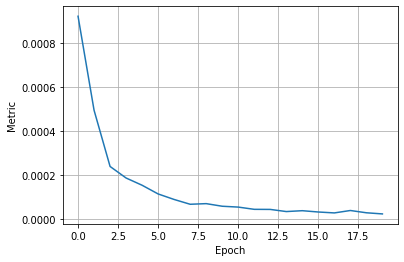

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0009220517443066985,
              0.0004944739763455365,
              0.00023872278966140286,
              0.00018623522491164672,
              0.00015326452452594922,
              0.0001137295218010178,
              8.857630874658972e-05,
              6.681863026581993e-05,
              6.966515046201499e-05,
              5.783747115623174e-05,
              5.3964532776083735e-05,
              4.376599395994671e-05,
              4.337213581959268e-05,
              3.363906571478315e-05,
              3.754780938041788e-05,
              3.162800217994513e-05,
              2.746862151590329e-05,
              3.844294151758614e-05,
              2.809521401192107e-05,
              2.2915382711507416e-05]})

In [ ]:
!nvidia-smi #reproducible on Tesla T4 

Sun Nov  6 17:25:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |    610MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# state = {
#             "arch": type(model).__name__,
#             "epoch": 20,
#             "state_dict": model.state_dict(),
#             "optimizer": opt.state_dict(),
#             "config": config,
#         }
# torch.save(state, 'base_model.pth')

In [24]:
checkpoint = torch.load('base_model.pth', config.device)
if checkpoint["config"] != config:
    print('different configs')
loaded_model = CRNN(checkpoint["config"]).to(config.device)
if checkpoint["arch"] != type(loaded_model).__name__:
    print('different architectures')
loaded_model.load_state_dict(checkpoint['state_dict'])

different configs


<All keys matched successfully>

In [ ]:
validation(loaded_model, val_loader, melspec_val, config.device)

102it [00:09, 10.48it/s]


2.2915382711507416e-05

loading works fine

# Evaluation funtions

In [25]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.5f}")

from thop import profile  # !pip install thop

# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Conv1d(1, 1, 3, bias=False)
    
#     def forward(self, x):
#         return self.model(x)
        
# profile(Model(), (torch.randn(1, 1, 4), ))  # -> (6.0 MACs, 3.0 parameters)

import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

# Distillation run 1


In [ ]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
student_config = TaskConfig()
student_config = TaskConfig(cnn_out_channels=4, hidden_size=16, num_epochs=40)
student_model = CRNN(student_config).to(student_config.device)
student_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
alpha_ce, alpha_mse = 1, 1
n_params = sum([p.numel() for p in student_model.parameters()])
wandb.init(
    project='kws',
    config = {
        'alpha_ce': alpha_ce,
        'alpha_mse': alpha_mse,
        'n_params': n_params,
        'student_config': student_config,
        }
    )

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)


In [ ]:
checkpoint = torch.load('distilled_model_best.pth', student_config.device)
if checkpoint["config"] != student_config:
    print('different configs')
student_model = CRNN(checkpoint["config"]).to(student_config.device)
if checkpoint["arch"] != type(student_model).__name__:
    print('different architectures')
student_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)

student_weight = get_size_in_megabytes(student_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of distilled model is: {au_fa_fr}, weight compression is: {student_weight/teacher_weight}')

102it [00:07, 13.41it/s]


Quality of distilled model is: 2.8930670673278113e-05, weight compression is: 0.287269817378133


In [ ]:
batch = torch.randn(1, 3 * 16000)[...,:2 * 16000]
batch = LogMelspec(is_train=False, config=TaskConfig)(batch.to(student_config.device))
prof_student = profile(student_model, (batch, ))
prof_teacher = profile(loaded_model, (batch, ))
print(f'Student model: { 2 * prof_student[0] / 1e3}k FLOPs, {prof_student[1] / 1e3}k parameters' )
print(f'Teacher model: {2 * prof_teacher[0] / 1e3}k FLOPs, {prof_teacher[1] / 1e3}k parameters' )

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Student model: 627.872k FLOPs, 6.679k parameters
Teacher model: 1809.216k FLOPs, 25.387k parameters


#Distillation run 2

In [ ]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
student_config = TaskConfig()
student_config = TaskConfig(cnn_out_channels=4, hidden_size=16, num_epochs=40, stride=(2, 10))
student_model = CRNN(student_config).to(student_config.device)
student_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
alpha_ce, alpha_mse = 1, 1
n_params = sum([p.numel() for p in student_model.parameters()])
wandb.init(
    project='kws',
    config = {
        'alpha_ce': alpha_ce,
        'alpha_mse': alpha_mse,
        'n_params': n_params,
        'student_config': student_config,
        }
    )

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 405/405 [00:42<00:00,  9.53it/s]
102it [00:06, 15.45it/s]
100%|██████████| 405/405 [00:37<00:00, 10.87it/s]
102it [00:05, 18.42it/s]
100%|██████████| 405/405 [00:35<00:00, 11.38it/s]
102it [00:05, 18.75it/s]
100%|██████████| 405/405 [00:34<00:00, 11.91it/s]
102it [00:05, 18.34it/s]
100%|██████████| 405/405 [00:33<00:00, 12.08it/s]
102it [00:05, 18.39it/s]
100%|██████████| 405/405 [00:33<00:00, 12.17it/s]
102it [00:05, 18.01it/s]
100%|██████████| 405/405 [00:33<00:00, 12.13it/s]
102it [00:05, 18.30it/s]
100%|██████████| 405/405 [00:33<00:00, 12.27it/s]
102it [00:05, 18.26it/s]
100%|██████████| 405/405 [00:32<00:00, 12.30it/s]
102it [00:05, 18.11it/s]
100%|██████████| 405/405 [00:32<00:00, 12.34it/s]
102it [00:05, 18.37it/s]
100%|██████████| 405/405 [00:32<00:00, 12.32it/s]
102it [00:05, 18.76it/s]
100%|██████████| 405/405 [00:32<00:00, 12.33it/s]
102it [00:05, 18.15it/s]
100%|██████████| 405/405 [00:33<00:00, 12.25it/s]
102it [00:05, 18.50it/s]
100%|██████████| 405/405 

In [ ]:
checkpoint = torch.load('distilled_model.pth', student_config.device)
if checkpoint["config"] != student_config:
    print('different configs')
student_model = CRNN(checkpoint["config"]).to(student_config.device)
if checkpoint["arch"] != type(student_model).__name__:
    print('different architectures')
student_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)

student_weight = get_size_in_megabytes(student_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of distilled model is: {au_fa_fr}, weight compression is: {teacher_weight/student_weight}')

Quality of distilled model is: 3.5477070369768646e-05, weight compression is: 3.2976475646459065


In [ ]:
batch = torch.randn(1, 3 * 16000)[...,:2 * 16000]
batch = LogMelspec(is_train=False, config=TaskConfig)(batch.to(student_config.device))
prof_student = profile(student_model, (batch, ))
prof_teacher = profile(loaded_model, (batch, ))
print(f'Student model: { 2 * prof_student[0] / 1e3}k FLOPs, {prof_student[1] / 1e3}k parameters' )
print(f'Teacher model: {2 * prof_teacher[0] / 1e3}k FLOPs, {prof_teacher[1] / 1e3}k parameters' )
print(f'Speedup: {prof_teacher[0] / prof_student[0]}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Student model: 518.688k FLOPs, 6.679k parameters
Teacher model: 1809.216k FLOPs, 25.387k parameters
Speedup: 3.4880621876735147


With bigger stride model became bit faster, size is the same

# Distillation 1 gru layer

In [ ]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

student_config = TaskConfig()
student_config = TaskConfig(cnn_out_channels=4, hidden_size=16, num_epochs=40, gru_num_layers=1)
student_model = CRNN(student_config).to(student_config.device)
student_model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
alpha_ce, alpha_mse = 1, 1
n_params = sum([p.numel() for p in student_model.parameters()])
wandb.init(
    project='kws',
    config = {
        'alpha_ce': alpha_ce,
        'alpha_mse': alpha_mse,
        'n_params': n_params,
        'student_config': student_config,
        }
    )

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)


au_fa_fr_val,█▅▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_ce,██▇▆▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_mse,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
au_fa_fr_val,4e-05
loss_ce,0.26499
loss_mse,0.65472


100%|██████████| 405/405 [00:34<00:00, 11.77it/s]
102it [00:05, 17.54it/s]
100%|██████████| 405/405 [00:34<00:00, 11.69it/s]
102it [00:05, 17.90it/s]
100%|██████████| 405/405 [00:33<00:00, 12.03it/s]
102it [00:05, 17.88it/s]
100%|██████████| 405/405 [00:33<00:00, 11.97it/s]
102it [00:05, 17.83it/s]
100%|██████████| 405/405 [00:33<00:00, 12.05it/s]
102it [00:05, 17.64it/s]
100%|██████████| 405/405 [00:33<00:00, 12.06it/s]
102it [00:05, 17.85it/s]
100%|██████████| 405/405 [00:33<00:00, 12.08it/s]
102it [00:05, 17.50it/s]
100%|██████████| 405/405 [00:33<00:00, 12.00it/s]
102it [00:05, 17.69it/s]
100%|██████████| 405/405 [00:33<00:00, 12.00it/s]
102it [00:05, 17.97it/s]
100%|██████████| 405/405 [00:33<00:00, 12.09it/s]
102it [00:05, 17.90it/s]
100%|██████████| 405/405 [00:33<00:00, 12.00it/s]
102it [00:05, 17.78it/s]
100%|██████████| 405/405 [00:33<00:00, 12.21it/s]
102it [00:05, 18.17it/s]
100%|██████████| 405/405 [00:33<00:00, 12.07it/s]
102it [00:05, 17.79it/s]
100%|██████████| 405/405 

In [ ]:
checkpoint = torch.load('distilled_model.pth', student_config.device)
if checkpoint["config"] != student_config:
    print('different configs')
student_model = CRNN(checkpoint["config"]).to(student_config.device)
if checkpoint["arch"] != type(student_model).__name__:
    print('different architectures')
student_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)

student_weight = get_size_in_megabytes(student_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of distilled model is: {au_fa_fr}, weight compression is: {teacher_weight/student_weight}')

102it [00:06, 16.04it/s]


Quality of distilled model is: 4.145058549847149e-05, weight compression is: 4.607113742652422


In [ ]:
batch = torch.randn(1, 3 * 16000)[...,:2 * 16000]
batch = LogMelspec(is_train=False, config=TaskConfig)(batch.to(student_config.device))
prof_student = profile(student_model, (batch, ))
prof_teacher = profile(loaded_model, (batch, ))
print(f'Student model: { 2 * prof_student[0] / 1e3}k FLOPs, {prof_student[1] / 1e3}k parameters' )
print(f'Teacher model: {2 * prof_teacher[0] / 1e3}k FLOPs, {prof_teacher[1] / 1e3}k parameters' )
print(f'Speedup: {prof_teacher[0] / prof_student[0]}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Student model: 547.648k FLOPs, 5.047k parameters
Teacher model: 1809.216k FLOPs, 25.387k parameters
Speedup: 3.3036110786490593


# Distillation stride 10 and hidden=12

In [27]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

student_config = TaskConfig()
student_config = TaskConfig(cnn_out_channels=2, hidden_size=16, num_epochs=20, gru_num_layers=1)
student_model = CRNN(student_config).to(student_config.device)
student_model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 16, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
alpha_ce, alpha_mse = 1, 2
n_params = sum([p.numel() for p in student_model.parameters()])
wandb.init(
    project='kws',
    config = {
        'alpha_ce': alpha_ce,
        'alpha_mse': alpha_mse,
        'n_params': n_params,
        'student_config': student_config,
        }
    )

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 405/405 [00:35<00:00, 11.42it/s]
102it [00:05, 18.16it/s]
100%|██████████| 405/405 [00:33<00:00, 12.18it/s]
102it [00:05, 18.20it/s]
100%|██████████| 405/405 [00:34<00:00, 11.76it/s]
102it [00:05, 17.86it/s]
100%|██████████| 405/405 [00:34<00:00, 11.66it/s]
102it [00:05, 18.01it/s]
100%|██████████| 405/405 [00:34<00:00, 11.72it/s]
102it [00:05, 17.87it/s]
100%|██████████| 405/405 [00:34<00:00, 11.75it/s]
102it [00:05, 17.69it/s]
100%|██████████| 405/405 [00:34<00:00, 11.83it/s]
102it [00:05, 18.15it/s]
100%|██████████| 405/405 [00:34<00:00, 11.76it/s]
102it [00:05, 18.02it/s]
100%|██████████| 405/405 [00:34<00:00, 11.77it/s]
102it [00:05, 17.64it/s]
100%|██████████| 405/405 [00:34<00:00, 11.82it/s]
102it [00:05, 18.12it/s]
100%|██████████| 405/405 [00:33<00:00, 12.02it/s]
102it [00:05, 17.57it/s]
100%|██████████| 405/405 [00:34<00:00, 11.90it/s]
102it [00:05, 18.27it/s]
100%|██████████| 405/405 [00:34<00:00, 11.83it/s]
102it [00:05, 17.77it/s]
100%|██████████| 405/405 

In [33]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=1e-4,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:33<00:00, 12.23it/s]
102it [00:05, 17.94it/s]
100%|██████████| 405/405 [00:32<00:00, 12.40it/s]
102it [00:05, 18.42it/s]
100%|██████████| 405/405 [00:32<00:00, 12.36it/s]
102it [00:05, 18.36it/s]
100%|██████████| 405/405 [00:34<00:00, 11.72it/s]
102it [00:05, 18.45it/s]
100%|██████████| 405/405 [00:32<00:00, 12.42it/s]
102it [00:05, 18.36it/s]
100%|██████████| 405/405 [00:34<00:00, 11.71it/s]
102it [00:06, 14.58it/s]
100%|██████████| 405/405 [00:32<00:00, 12.41it/s]
102it [00:05, 18.39it/s]
100%|██████████| 405/405 [00:39<00:00, 10.22it/s]
102it [00:05, 18.51it/s]
100%|██████████| 405/405 [00:33<00:00, 12.20it/s]
102it [00:05, 18.27it/s]
100%|██████████| 405/405 [00:44<00:00,  9.19it/s]
102it [00:07, 13.15it/s]
100%|██████████| 405/405 [00:34<00:00, 11.72it/s]
102it [00:05, 17.87it/s]
100%|██████████| 405/405 [00:36<00:00, 11.15it/s]
102it [00:05, 17.76it/s]
100%|██████████| 405/405 [00:34<00:00, 11.71it/s]
102it [00:05, 18.07it/s]
100%|██████████| 405/405 

In [36]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=1e-4,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:35<00:00, 11.37it/s]
102it [00:05, 17.97it/s]
100%|██████████| 405/405 [00:34<00:00, 11.71it/s]
102it [00:05, 18.06it/s]
100%|██████████| 405/405 [00:34<00:00, 11.78it/s]
102it [00:06, 15.97it/s]
100%|██████████| 405/405 [00:33<00:00, 12.03it/s]
102it [00:05, 17.93it/s]
100%|██████████| 405/405 [00:32<00:00, 12.31it/s]
102it [00:05, 17.84it/s]
100%|██████████| 405/405 [00:33<00:00, 12.17it/s]
102it [00:05, 17.84it/s]
100%|██████████| 405/405 [00:33<00:00, 12.22it/s]
102it [00:05, 18.33it/s]
100%|██████████| 405/405 [00:33<00:00, 12.18it/s]
102it [00:05, 18.08it/s]
100%|██████████| 405/405 [00:33<00:00, 12.23it/s]
102it [00:05, 18.32it/s]
100%|██████████| 405/405 [00:33<00:00, 12.19it/s]
102it [00:05, 18.30it/s]
100%|██████████| 405/405 [00:32<00:00, 12.28it/s]
102it [00:05, 18.26it/s]
100%|██████████| 405/405 [00:32<00:00, 12.34it/s]
102it [00:05, 18.15it/s]
100%|██████████| 405/405 [00:33<00:00, 12.26it/s]
102it [00:05, 17.98it/s]
100%|██████████| 405/405 

In [39]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=5e-5,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:33<00:00, 12.06it/s]
102it [00:05, 18.42it/s]
100%|██████████| 405/405 [00:33<00:00, 11.97it/s]
102it [00:05, 18.01it/s]
100%|██████████| 405/405 [00:34<00:00, 11.88it/s]
102it [00:05, 17.70it/s]
100%|██████████| 405/405 [00:34<00:00, 11.84it/s]
102it [00:05, 18.19it/s]
100%|██████████| 405/405 [00:34<00:00, 11.81it/s]
102it [00:05, 17.24it/s]
100%|██████████| 405/405 [00:35<00:00, 11.51it/s]
102it [00:08, 12.22it/s]
100%|██████████| 405/405 [00:53<00:00,  7.51it/s]
102it [00:05, 18.11it/s]
100%|██████████| 405/405 [00:40<00:00,  9.99it/s]
102it [00:08, 12.62it/s]
100%|██████████| 405/405 [00:43<00:00,  9.25it/s]
102it [00:06, 15.95it/s]
100%|██████████| 405/405 [00:38<00:00, 10.57it/s]
102it [00:10,  9.99it/s]
100%|██████████| 405/405 [00:44<00:00,  9.19it/s]
102it [00:05, 18.08it/s]
100%|██████████| 405/405 [00:45<00:00,  8.86it/s]
102it [00:07, 13.60it/s]
100%|██████████| 405/405 [00:39<00:00, 10.16it/s]
102it [00:07, 13.92it/s]
100%|██████████| 405/405 

In [40]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=5e-5,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:35<00:00, 11.43it/s]
102it [00:05, 17.69it/s]
100%|██████████| 405/405 [00:50<00:00,  7.99it/s]
102it [00:08, 11.97it/s]
100%|██████████| 405/405 [00:45<00:00,  8.99it/s]
102it [00:07, 12.81it/s]
100%|██████████| 405/405 [00:34<00:00, 11.63it/s]
102it [00:05, 17.89it/s]
100%|██████████| 405/405 [00:35<00:00, 11.43it/s]
102it [00:05, 17.83it/s]
100%|██████████| 405/405 [00:35<00:00, 11.56it/s]
102it [00:07, 13.99it/s]
100%|██████████| 405/405 [00:35<00:00, 11.56it/s]
102it [00:05, 17.89it/s]
100%|██████████| 405/405 [00:35<00:00, 11.51it/s]
102it [00:05, 17.74it/s]
100%|██████████| 405/405 [00:36<00:00, 11.13it/s]
102it [00:05, 17.73it/s]
100%|██████████| 405/405 [00:34<00:00, 11.59it/s]
102it [00:05, 18.01it/s]
100%|██████████| 405/405 [00:35<00:00, 11.56it/s]
102it [00:05, 17.57it/s]
100%|██████████| 405/405 [00:34<00:00, 11.63it/s]
102it [00:05, 17.72it/s]
100%|██████████| 405/405 [00:35<00:00, 11.53it/s]
102it [00:05, 17.52it/s]
100%|██████████| 405/405 

In [43]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=5e-5,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:32<00:00, 12.48it/s]
102it [00:05, 18.24it/s]
100%|██████████| 405/405 [00:32<00:00, 12.54it/s]
102it [00:05, 18.33it/s]
100%|██████████| 405/405 [00:33<00:00, 12.20it/s]
102it [00:05, 18.82it/s]
100%|██████████| 405/405 [00:32<00:00, 12.33it/s]
102it [00:05, 18.34it/s]
100%|██████████| 405/405 [00:32<00:00, 12.45it/s]
102it [00:05, 18.32it/s]
100%|██████████| 405/405 [00:32<00:00, 12.54it/s]
102it [00:05, 18.62it/s]
100%|██████████| 405/405 [00:32<00:00, 12.50it/s]
102it [00:05, 18.38it/s]
100%|██████████| 405/405 [00:32<00:00, 12.51it/s]
102it [00:05, 18.34it/s]
100%|██████████| 405/405 [00:33<00:00, 12.26it/s]
102it [00:05, 18.50it/s]
100%|██████████| 405/405 [00:34<00:00, 11.71it/s]
102it [00:05, 18.25it/s]
100%|██████████| 405/405 [00:34<00:00, 11.72it/s]
102it [00:05, 17.62it/s]
100%|██████████| 405/405 [00:34<00:00, 11.72it/s]
102it [00:05, 17.70it/s]
100%|██████████| 405/405 [00:34<00:00, 11.81it/s]
102it [00:05, 17.72it/s]
100%|██████████| 405/405 

In [ ]:
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=5e-5,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

100%|██████████| 405/405 [00:40<00:00, 10.03it/s]
102it [00:05, 17.81it/s]
100%|██████████| 405/405 [00:33<00:00, 12.01it/s]
102it [00:05, 18.18it/s]
100%|██████████| 405/405 [00:34<00:00, 11.73it/s]
102it [00:05, 18.06it/s]
100%|██████████| 405/405 [00:33<00:00, 12.14it/s]
102it [00:05, 18.23it/s]
100%|██████████| 405/405 [00:34<00:00, 11.82it/s]
102it [00:05, 17.39it/s]
100%|██████████| 405/405 [00:32<00:00, 12.48it/s]
102it [00:05, 18.48it/s]
100%|██████████| 405/405 [00:38<00:00, 10.61it/s]
102it [00:10, 10.03it/s]
100%|██████████| 405/405 [00:47<00:00,  8.52it/s]
102it [00:05, 17.85it/s]
100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 18.03it/s]
100%|██████████| 405/405 [00:36<00:00, 11.05it/s]
102it [00:11,  8.74it/s]
100%|██████████| 405/405 [00:36<00:00, 11.06it/s]
102it [00:05, 18.36it/s]
 82%|████████▏ | 331/405 [00:27<00:06, 12.00it/s]

In [28]:
checkpoint = torch.load('distilled_model_1.pth', student_config.device)
if checkpoint["config"] != student_config:
    print('different configs')
student_model = CRNN(checkpoint["config"]).to(student_config.device)
if checkpoint["arch"] != type(student_model).__name__:
    print('different architectures')
student_model.load_state_dict(checkpoint['state_dict'])

different configs


<All keys matched successfully>

In [30]:
alpha_ce, alpha_mse = 1, 2
n_params = sum([p.numel() for p in student_model.parameters()])
wandb.init(
    project='kws',
    config = {
        'alpha_ce': alpha_ce,
        'alpha_mse': alpha_mse,
        'n_params': n_params,
        'student_config': student_config,
        }
    )

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=5e-5,
    weight_decay=student_config.weight_decay
)

loaded_model.eval()
student_model.train()
best_metric = 10

for n in range(student_config.num_epochs):
    student_model.train()
    ce_losses, mse_losses = [], []
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(student_config.device), labels.to(student_config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = student_model(batch)
        with torch.no_grad():
            teacher_logits = loaded_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_ce = F.cross_entropy(logits, labels)
        loss_mse = F.mse_loss(logits, teacher_logits)
        ce_losses.append(loss_ce.item())
        mse_losses.append(loss_mse.item())
        
        loss = alpha_ce * loss_ce + alpha_mse * loss_mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    
    au_fa_fr = validation(student_model, val_loader,
                        melspec_val, student_config.device)
    
    if au_fa_fr < best_metric:
        best_metric = au_fa_fr
        state = {
            "arch": type(student_model).__name__,
            "state_dict": student_model.state_dict(),
            "config": student_config,
        }
        torch.save(state, 'distilled_model.pth')
        wandb.save('distilled_model.pth')

    metrics = {
        'loss_ce': np.mean(ce_losses),
        'loss_mse': np.mean(mse_losses),
        'au_fa_fr_val': au_fa_fr
        }
    wandb.log(metrics)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 405/405 [01:04<00:00,  6.27it/s]
102it [00:16,  6.16it/s]
100%|██████████| 405/405 [01:07<00:00,  5.98it/s]
102it [00:10, 10.03it/s]
100%|██████████| 405/405 [01:04<00:00,  6.23it/s]
102it [00:10,  9.42it/s]
100%|██████████| 405/405 [01:03<00:00,  6.33it/s]
102it [00:10,  9.76it/s]
100%|██████████| 405/405 [01:03<00:00,  6.41it/s]
102it [00:10,  9.75it/s]
100%|██████████| 405/405 [01:03<00:00,  6.42it/s]
102it [00:10,  9.74it/s]
100%|██████████| 405/405 [01:03<00:00,  6.42it/s]
102it [00:10,  9.66it/s]
100%|██████████| 405/405 [01:02<00:00,  6.46it/s]
102it [00:10,  9.80it/s]
100%|██████████| 405/405 [01:03<00:00,  6.41it/s]
102it [00:10,  9.69it/s]
100%|██████████| 405/405 [01:03<00:00,  6.40it/s]
102it [00:10,  9.70it/s]
100%|██████████| 405/405 [01:05<00:00,  6.18it/s]
102it [00:10,  9.76it/s]
100%|██████████| 405/405 [01:02<00:00,  6.48it/s]
102it [00:10,  9.78it/s]
100%|██████████| 405/405 [01:02<00:00,  6.47it/s]
102it [00:10,  9.61it/s]
100%|██████████| 405/405 

In [31]:
checkpoint = torch.load('distilled_model.pth', student_config.device)
if checkpoint["config"] != student_config:
    print('different configs')
student_model = CRNN(checkpoint["config"]).to(student_config.device)
if checkpoint["arch"] != type(student_model).__name__:
    print('different architectures')
student_model.load_state_dict(checkpoint['state_dict'])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [32]:
au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)

student_weight = get_size_in_megabytes(student_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of distilled model is: {au_fa_fr}, weight compression is: {teacher_weight/student_weight}')

102it [00:10,  9.40it/s]


Quality of distilled model is: 7.762585893523137e-05, weight compression is: 6.626898318855072


In [33]:
batch = torch.randn(1, 3 * 16000)[...,:2 * 16000]
batch = LogMelspec(is_train=False, config=TaskConfig)(batch.to(student_config.device))
prof_student = profile(student_model, (batch, ))
prof_teacher = profile(loaded_model, (batch, ))
print(f'Student model: { 2 * prof_student[0] / 1e3}k FLOPs, {prof_student[1] / 1e3}k parameters' )
print(f'Teacher model: {2 * prof_teacher[0] / 1e3}k FLOPs, {prof_teacher[1] / 1e3}k parameters' )
print(f'Speedup: {prof_teacher[0] / prof_student[0]}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Student model: 302.56k FLOPs, 3.117k parameters
Teacher model: 1809.216k FLOPs, 25.387k parameters
Speedup: 5.979693283976732


#quantization

Во время прошлого экспа квота на гпу в колабе кончилась, теперь воспроизводимость поломается

In [52]:
SEED = 7
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

distilled_config = TaskConfig()
distilled_config = TaskConfig(cnn_out_channels=4, hidden_size=16, num_epochs=40, gru_num_layers=1)
distilled_model = CRNN(distilled_config).to(distilled_config.device)
distilled_model

checkpoint = torch.load('distilled_stride10_model.pth', distilled_config.device)
if checkpoint["config"] != distilled_config:
    print('different configs')
distilled_model = CRNN(checkpoint["config"]).to(distilled_config.device)
if checkpoint["arch"] != type(distilled_model).__name__:
    print('different architectures')
for key in ["total_ops", "total_params", "conv.1.total_ops", "conv.1.total_params", "attention.total_ops", "attention.total_params", "attention.energy.1.total_ops", "attention.energy.1.total_params"]:
    del checkpoint['state_dict'][key] #в последний момент сломалась загрузка 

distilled_model.load_state_dict(checkpoint['state_dict'])

different configs


<All keys matched successfully>

In [53]:
au_fa_fr = validation(distilled_model, val_loader,
                          melspec_val, config.device)

distilled_weight = get_size_in_megabytes(distilled_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of distilled model is: {au_fa_fr}, weight compression is: {teacher_weight/distilled_weight}')

102it [00:10,  9.60it/s]


Quality of distilled model is: 5.577866724074474e-05, weight compression is: 3.4755132763204255


Было меньше 5.5е-5, есть логи на вандб(

In [54]:
import torch.quantization

In [55]:
fp16_model = torch.quantization.quantize_dynamic(distilled_model, dtype=torch.float16)

In [56]:
au_fa_fr = validation(fp16_model, val_loader,
                          melspec_val, config.device)

fp16_weight = get_size_in_megabytes(fp16_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of fp16 quantized model is: {au_fa_fr}, weight compression is: {teacher_weight/fp16_weight}')

102it [00:12,  8.19it/s]


Quality of fp16 quantized model is: 5.579060233590698e-05, weight compression is: 3.201705467528252


In [57]:
state = {
            "arch": type(fp16_model).__name__,
            "state_dict": fp16_model.state_dict(),
            "config": student_config,
        }
torch.save(state, 'fp16_model.pth')

In [58]:
qint8_model = torch.quantization.quantize_dynamic(distilled_model, dtype=torch.qint8)

In [59]:
au_fa_fr = validation(qint8_model, val_loader,
                          melspec_val, config.device)

qint8_weight = get_size_in_megabytes(qint8_model)
teacher_weight = get_size_in_megabytes(loaded_model)
print(f'Quality of qint8 quantized model is: {au_fa_fr}, weight compression is: {teacher_weight/qint8_weight}')

102it [00:10,  9.58it/s]


Quality of qint8 quantized model is: 5.692443637632013e-05, weight compression is: 6.8490184939721015


In [61]:
state = {
            "arch": type(qint8_model).__name__,
            "state_dict": qint8_model.state_dict(),
            "config": student_config,
        }
torch.save(state, 'qint8_model.pth')

Качество после кавнтизации почти не падает, от qint8 сжатие усилилось двукратно, если бы не проблема с воспроизводимостью наверно норм модели были бы

#plots


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'metric': [],
    'FLOPs': [],
    'memory': [],
    'name': []
        }

# for name in ['qint8', 'fp16', 'base', 'distilled_stride10']:
#     checkpoint = torch.load(name + '_model.pth')
#     if name != 'base':
#         conf = distilled_config
#     else:
#         conf = config
#     loaded = CRNN(checkpoint["config"]).to(conf.device)
#     loaded = loaded.load_state_dict(checkpoint['state_dict'])

#     weight  = get_size_in_megabytes(loaded)
#     au_fa_fr = validation(loaded, val_loader,
#                           melspec_val, conf.device)
#     prof = profile(loaded, (batch, ))

#     data['name'].append(name)
#     data['memory'].append(weight)
#     data['metric'].append(au_fa_fr)
#     data['FLOPs'].append(2 * prof[0])

# checkpoint = torch.load('base_model.pth', map_location=torch.device('cpu'))
# conf = config
# loaded = CRNN(checkpoint["config"]).to(distilled_config.device)
# loaded = loaded.load_state_dict(checkpoint['state_dict'])

# weight  = get_size_in_megabytes(loaded)
# au_fa_fr = validation(loaded, val_loader,
#                         melspec_val, conf.device)
# prof = profile(loaded, (batch, ))

# data['name'].append('base_model')
# data['memory'].append(weight)
# data['metric'].append(au_fa_fr)
# data['FLOPs'].append(2 * prof[0])

checkpoint = torch.load('distilled_stride10_model.pth')
conf = distilled_config
loaded = CRNN(checkpoint["config"]).to(conf.device)
loaded = loaded.load_state_dict(checkpoint['state_dict'])

weight  = get_size_in_megabytes(loaded)
au_fa_fr = validation(loaded, val_loader,
                        melspec_val, conf.device)
prof = profile(loaded, (batch, ))

data['name'].append('distilled_model')
data['memory'].append(weight)
data['metric'].append(au_fa_fr)
data['FLOPs'].append(2 * prof[0])

checkpoint = torch.load('qint8_model.pth')
conf = distilled_config
loaded = CRNN(checkpoint["config"]).to(conf.device)
loaded = loaded.load_state_dict(checkpoint['state_dict'])

weight  = get_size_in_megabytes(loaded)
au_fa_fr = validation(loaded, val_loader,
                        melspec_val, conf.device)
prof = profile(loaded, (batch, ))

data['name'].append('qint8_model')
data['memory'].append(weight)
data['metric'].append(au_fa_fr)
data['FLOPs'].append(2 * prof[0])

checkpoint = torch.load('fp16_model.pth')
conf = distilled_config
loaded = CRNN(checkpoint["config"]).to(conf.device)
loaded = loaded.load_state_dict(checkpoint['state_dict'])

weight  = get_size_in_megabytes(loaded)
au_fa_fr = validation(loaded, val_loader,
                        melspec_val, conf.device)
prof = profile(loaded, (batch, ))

data['name'].append('fp16_model')
data['memory'].append(weight)
data['metric'].append(au_fa_fr)
data['FLOPs'].append(2 * prof[0])

RuntimeError: ignored

In [ ]:
sns.lineplot(data = data, x='metric', y = 'flops')

In [ ]:
sns.lineplot(data = data, x='metric', y = 'memory')

# Streaming

In [109]:
class CRNN_streaming():

    def __init__(self, config: TaskConfig, model: CRNN):
        self.window_length = config.max_window_length
        self.hidden = None
        self.buffer = torch.zeros([1, 1, config.n_mels, 0]).to(config.device)
        self.gru_buffer = torch.zeros([1, 0, config.hidden_size]).to(config.device)
        self.model = model
        
    
    def forward(self, input):
        with torch.inference_mode():
            input = input.unsqueeze(dim=1)
            # print(self.buffer.shape, input.shape)
            self.buffer = torch.cat([self.buffer, input], dim = -1)
            if self.buffer.shape[-1] > self.window_length:
                self.buffer = self.buffer[:,:,:,-self.window_length:]
            # print(self.buffer.shape)
            if self.buffer.shape[-1] < config.kernel_size[1]:
                # print('buffer is smaller than receptive field')
                return 0
            
            conv_output = self.model.conv(self.buffer).transpose(-1, -2)
            gru_output, self.hidden = self.model.gru(conv_output, self.hidden)
            # print(self.gru_buffer.shape, gru_output.shape)
            self.gru_buffer = torch.cat([self.gru_buffer, gru_output], dim = 1)
            if self.gru_buffer.shape[1] > self.window_length:
                self.gru_buffer = self.gru_buffer[:,1:,:]
            contex_vector = self.model.attention(self.gru_buffer)
            output = self.model.classifier(contex_vector)
        return output

class CRNN_streaming_full():
    #version with argmax and melspec for saving
    def __init__(self, config: TaskConfig, model: CRNN):
        self.window_length = config.max_window_length
        self.hidden = None
        self.buffer = torch.zeros([1, 1, config.n_mels, 0]).to(config.device)
        self.gru_buffer = torch.zeros([1, 0, config.hidden_size]).to(config.device)
        self.model = model
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)
    def call_melspec(self, batch):
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

    def forward(self, input):
        input = self.call_melspec(input)
        with torch.inference_mode():
            input = input.unsqueeze(dim=1)
            # print(self.buffer.shape, input.shape)
            self.buffer = torch.cat([self.buffer, input], dim = -1)
            if self.buffer.shape[-1] > self.window_length:
                self.buffer = self.buffer[:,:,:,-self.window_length:]
            # print(self.buffer.shape)
            if self.buffer.shape[-1] < config.kernel_size[1]:
                # print('buffer is smaller than receptive field')
                return 0
            
            conv_output = self.model.conv(self.buffer).transpose(-1, -2)
            gru_output, self.hidden = self.model.gru(conv_output, self.hidden)
            # print(self.gru_buffer.shape, gru_output.shape)
            self.gru_buffer = torch.cat([self.gru_buffer, gru_output], dim = 1)
            if self.gru_buffer.shape[1] > self.window_length:
                self.gru_buffer = self.gru_buffer[:,1:,:]
            contex_vector = self.model.attention(self.gru_buffer)
            output = self.model.classifier(contex_vector)
        return F.softmax(output[0], dim=0)[1].item()

In [79]:
zeros = []
i = 0
while len(zeros) < 20:
    x, y = val_set[i]['wav'], val_set[i]['label']
    if y == 0:
        zeros.append(x)
    i += 1

sheila = []
while len(sheila) != 1:
    x, y = val_set[i]['wav'], val_set[i]['label']
    if y == 1:
        sheila.append(x)
    i += 1

In [87]:
batch = []
for x in zeros[:10] + sheila + zeros[10:]:
    x = melspec_val(x)
    batch.append(x)

In [99]:
batch = torch.cat(batch, dim = 1)
batch = batch.unsqueeze(dim=0)

In [103]:
batch.shape

torch.Size([1, 40, 2121])

In [129]:
batch.shape[2] / 21

101.0

In [141]:
streaming = CRNN_streaming(distilled_config, distilled_model)
outputs = []

for i in range(0, batch.shape[2], distilled_config.stride[1]):
    output = streaming.forward(batch[:, :, i:i+distilled_config.stride[1]])
    if type(output) == torch.Tensor:
        outputs.append(F.softmax(output[0], dim=0)[1].item())
    else:
        outputs.append(0)

In [ ]:
outputs

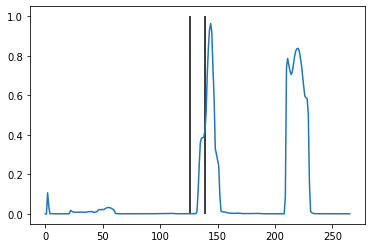

In [136]:
sns.lineplot(data=outputs)
plt.vlines([batch.shape[2] / 21 * 10 / distilled_config.stride[1], batch.shape[2] / 21 * 11 / distilled_config.stride[1]], ymin=0, ymax=1)

Небольшая задержка + ложное срабатывание в конце

In [138]:
# streaming_full = CRNN_streaming_full(distilled_config, distilled_model)
m = torch.jit.script(CRNN_streaming_full(distilled_config, distilled_model))
m.save("streaming.pt")

TypeError: ignored

Из за своей кривой реализации (не унаследовался) не могу сохранить стриминговую модель